In [1]:
import cv2
import numpy as np
from scipy import ndimage
import scipy
from scipy import ndimage
import imageio
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from numpy import array, zeros, abs, sqrt, arctan2, arctan, pi, real
from numpy.fft import fft2, ifft2

In [2]:
def to_shape(a, shape):
    b = np.zeros(shape)
    b[:a.shape[0], :a.shape[1]] = a
    return b


# non max suppression from https://github.com/fatihsennik/OpenCV-Canny-Edge-Detection/tree/master/code bc no existing function in opencv/scipy
def nonmax_suppression(det, phase):
    gmax = zeros(det.shape)
    for i in range(gmax.shape[0]):
        for j in range(gmax.shape[1]):
            if phase[i][j] < 0:
                phase[i][j] += 360

            if ((j + 1) < gmax.shape[1]) and ((j - 1) >= 0) and ((i + 1) < gmax.shape[0]) and ((i - 1) >= 0):
                # 0 degrees
                if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
                    if det[i][j] >= det[i][j + 1] and det[i][j] >= det[i][j - 1]:
                        gmax[i][j] = det[i][j]
                # 45 degrees
                if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
                    if det[i][j] >= det[i - 1][j + 1] and det[i][j] >= det[i + 1][j - 1]:
                        gmax[i][j] = det[i][j]
                # 90 degrees
                if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
                    if det[i][j] >= det[i - 1][j] and det[i][j] >= det[i + 1][j]:
                        gmax[i][j] = det[i][j]
                # 135 degrees
                if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
                    if det[i][j] >= det[i - 1][j - 1] and det[i][j] >= det[i + 1][j + 1]:
                        gmax[i][j] = det[i][j]
    return gmax
from scipy import signal
def nonmax_suppression_conv(det, phase):
    kernel = { 
        'up': [[0,-1,0],[0,1,0],[0,0,0]],
        'down': [[0,0,0],[0,1,0],[0,-1,0]],
        'left': [[0,0,0],[-1,1,0],[0,0,0]],
        'right': [[0,0,0],[0,1,-1],[0,0,0]],
        'up_left': [[-1,0,0],[0,1,0],[0,0,0]],
        'down_left': [[0,0,0],[0,1,0],[-1,0,0]],
        'up_right': [[0,0,-1],[0,1,0],[0,0,0]],
        'down_right': [[0,0,0],[0,1,0],[0,0,-1]],
    }

    phase[ phase < 0 ] += 360

    output = np.zeros(phase.shape)
    # print(phase.shape)

    output = np.logical_and ( np.greater(signal.convolve2d(det, kernel['left'],mode='same'), 0), np.greater(scipy.signal.convolve2d(det, kernel['right'],mode='same'), 0), where=(phase >= 337.5) | (phase < 22.5) | ((phase >= 157.5) & (phase < 202.5))) \
    | np.logical_and ( np.greater(signal.convolve2d(det, kernel['down_left'],mode='same'), 0), np.greater(scipy.signal.convolve2d(det, kernel['up_right'],mode='same'), 0), where=((phase >= 22.5) & (phase < 67.5)) | ((phase >= 202.5) & (phase < 247.5))) \
    | np.logical_and ( np.greater(signal.convolve2d(det, kernel['up'],mode='same'), 0), np.greater(scipy.signal.convolve2d(det, kernel['down'],mode='same'), 0), where=((phase >= 67.5) & (phase < 112.5)) | ((phase >= 247.5) & (phase < 292.5))) \
    | np.logical_and ( np.greater(signal.convolve2d(det, kernel['up_left'],mode='same'), 0), np.greater(scipy.signal.convolve2d(det, kernel['down_right'],mode='same'), 0), where=((phase >= 112.5) & (phase < 157.5)) | ((phase >= 292.5) & (phase < 337.5)))

    return np.where(output, det, 0)

In [3]:
start = time.time()
frame = cv2.imread("small.jpeg")
canny = cv2.Canny(frame, 100, 110)
sigma = 7
    # frame2 = cv2.medianBlur(frame, sigma)
frame2 = cv2.GaussianBlur(frame, (sigma,sigma), 0)
im = frame2.astype('int32')
end = time.time()

print(end-start)

0.05893135070800781


In [4]:
start = time.time()

horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # s2
vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # s1
gray_img = np.round(0.299 * im[:, :, 0] +
                    0.587 * im[:, :, 1] +
                    0.114 * im[:, :, 2]).astype(np.uint8)

img_fft = np.fft.fft2(gray_img)
horizontal_kernel_fft =  np.fft.fft2(to_shape(horizontal, gray_img.shape))
vertical_kernel_fft =  np.fft.fft2(to_shape(vertical, gray_img.shape) )


newverticalImage = real(np.fft.ifft2( img_fft * vertical_kernel_fft )).astype(float)
newhorizontalImage = real(np.fft.ifft2( img_fft * horizontal_kernel_fft )).astype(float)

    

sobel_fft = abs( np.sqrt(pow(newverticalImage, 2) + pow(newhorizontalImage, 2)) ).astype(float)
angle = arctan2(newverticalImage, newhorizontalImage) * 180 / pi
       
sobel_fft[sobel_fft<max(sobel_fft.flatten())*.05] = 0
sobel_non_max = nonmax_suppression_conv(sobel_fft, angle)
end = time.time()

print(end-start)

0.12764239311218262


In [5]:
start = time.time()

horizontal = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])  # s2
vertical = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])  # s1
gray_img = np.round(0.299 * im[:, :, 0] +
                    0.587 * im[:, :, 1] +
                    0.114 * im[:, :, 2]).astype(np.uint8)

img_fft = np.fft.fft2(gray_img)
horizontal_kernel_fft =  np.fft.fft2(to_shape(horizontal, gray_img.shape))
vertical_kernel_fft =  np.fft.fft2(to_shape(vertical, gray_img.shape) )


newverticalImage = real(np.fft.ifft2( img_fft * vertical_kernel_fft )).astype(float)
newhorizontalImage = real(np.fft.ifft2( img_fft * horizontal_kernel_fft )).astype(float)


prewitt_fft = abs( np.sqrt(pow(newverticalImage, 2) + pow(newhorizontalImage, 2)) ).astype(float)
angle = arctan2(newverticalImage, newhorizontalImage) * 180 / pi
    # prewitt_fft = nonmax_suppression(prewitt_fft, angle)

    
prewitt_fft = prewitt_fft.astype(np.uint8)
    # prewitt_fft = cv2.adaptiveThreshold(prewitt_fft,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                 cv2.THRESH_BINARY_INV,7,10)
    
    # prewitt_fft = 255-prewitt_fft
prewitt_fft[prewitt_fft<max(prewitt_fft.flatten())*.1] = 0
end = time.time()

print(end-start)

0.0735170841217041


In [6]:
start = time.time()

horizontal = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) #positive laplachian
    # horizontal = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) #negative laplachian
vertical = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) 
gray_img = np.round(0.299 * im[:, :, 0] +
                    0.587 * im[:, :, 1] +
                    0.114 * im[:, :, 2]).astype(np.uint8)

img_fft = np.fft.fft2(gray_img)
horizontal_kernel_fft =  np.fft.fft2(to_shape(horizontal, gray_img.shape))
vertical_kernel_fft =  np.fft.fft2(to_shape(vertical, gray_img.shape) )


newverticalImage = real(np.fft.ifft2( img_fft * vertical_kernel_fft )).astype(float)
newhorizontalImage = real(np.fft.ifft2( img_fft * horizontal_kernel_fft )).astype(float)


laplachian_fft = abs( np.sqrt(pow(newverticalImage, 2) + pow(newhorizontalImage, 2)) ).astype(float)
angle = arctan2(newverticalImage, newhorizontalImage) * 180 / pi
    # laplachian_fft = nonmax_suppression(laplachian_fft, angle)

    
laplachian_fft = laplachian_fft.astype(np.uint8)

    # laplachian_fft = cv2.adaptiveThreshold(laplachian_fft,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                 cv2.THRESH_BINARY_INV,7,10)
    
    # laplachian_fft = 255-prewitt_fft
laplachian_fft[laplachian_fft<max(laplachian_fft.flatten())*.007] = 0
end = time.time()

print(end-start)

0.07538819313049316


In [7]:
cv2.imwrite("normal.jpeg", frame)
    # cv2.imshow("edge detection sobel", sobel_fft)
cv2.imwrite("sobel.jpeg", sobel_non_max)
cv2.imwrite("prewitt.jpeg", prewitt_fft)
cv2.imwrite("laplachian.jpeg", laplachian_fft)
    #cv2.imshow("edge detection sobel and laplachian", laplachian_fft)

   # cv2.imshow("morphological edge out", morph)
cv2.imwrite("canny.jpeg", canny)

True

In [21]:
import numpy as np 
import cv2
import time
from pynq import Overlay
import pynq.lib.dma
from pynq import allocate
import random
import matplotlib.pyplot as plt
import time

OVERLAY = './canny_dma.bit'

In [22]:
ol = Overlay(OVERLAY)
dma = ol.axi_dma_0

in_buffer = allocate(shape=(100,100), dtype=np.uint8)
out_buffer = allocate(shape=(100,100), dtype=np.uint8)
#CREATE CONTIGOUS MEMORY ALLOCATED BUFFERS THROUGH XLNK

In [23]:
from pynq import MMIO
ip = MMIO(0x43C00000,0x10000)
ip.write(0x10 , 150 % 256)
ip.write(0x18,100 % 256)
ip.read(0x10)
ip.read(0x18)
#SET THE REGISTER'S VALUES OF HYSTHERESIS 

100

In [24]:
img = cv2.imread('./small.jpg', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#LOAD THE IMAGE AND CONVERT TO GRAY

In [ ]:
dma.sendchannel.start()
dma.recvchannel.start()
#START THE DMA

In [ ]:
img = cv2.imread('./small.jpg', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
np.copyto(in_buffer,img)

t = time.time()

dma.sendchannel.transfer(in_buffer)

dma.recvchannel.transfer(out_buffer)

print(time.time() - t)
#EXECUTE THE TRANSFER FROM PS --> PL AND PL --> PS

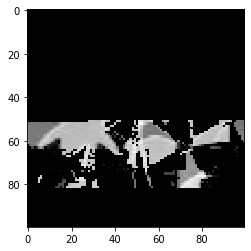

In [27]:
plt.imshow(out_buffer, cmap='gray')